In [1]:
import numpy as np

# ckeck ULA.py

In [2]:
from ULA import ULA_with_burnin, ULA_from_initial, generate_test_trajetories, generate_train_trajectories, plot_distr

In [73]:
# def f_grad(x):
#     a = np.ones(2) / np.sqrt(2*2)
#     return x-a+5*a/(1 + np.exp(2* (x.T @ a)))

In [134]:
def f_grad(x):
    a = np.ones(2) / np.sqrt(2*2)
    return x-2*a+5*a/(1 + np.exp(2* (x.T @ a)))

In [137]:
np.random.seed(2342)
X, G, Z = ULA_with_burnin(d=2,step=0.1,burn_in=10000,n=100000,f_grad=f_grad)

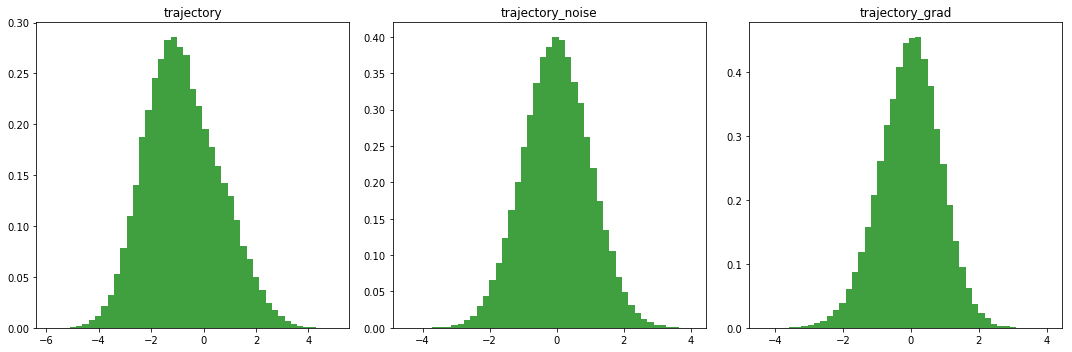

In [148]:
plot_distr(X,Z,G,1)

In [139]:
# X_tr, G_tr, Z_tr = ULA_from_initial(d=8, step=0.1, x_initial=X[0],n = 10000, f_grad=f_grad)

In [140]:
# plt.figure(figsize=(10,10))
# n, bins, patches = plt.hist(X_tr[:,1].reshape(-1,1), 25, density=True, facecolor='g', alpha=0.75)
# x = np.linspace(-5,5,100)
# plt.show()

In [141]:
np.random.seed(123)
XX, GG, ZZ = generate_train_trajectories(X, N_train=200,d = 2, step = 0.1, n = 1000, f_grad=f_grad)

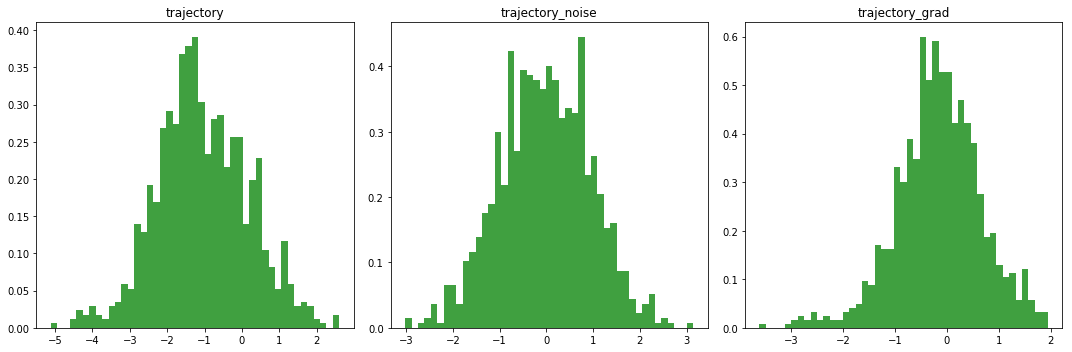

In [142]:
plot_distr(XX[0], ZZ[0], GG[0], 1)

In [143]:
np.random.seed(123)
XX_test, GG_test, ZZ_test = generate_test_trajetories(N_test=50, d =2, step=0.1, burn_in=10000, n = 1000, f_grad=f_grad)

In [144]:
XX_test.shape

(50, 1000, 2)

In [145]:
XX_test[0,5]

array([-0.12310096, -0.03767309])

In [146]:
XX_test[0,4] - 0.1 * GG_test[0,4] + np.sqrt(2 * 0.1) * ZZ_test[0,5]

array([-0.12310096, -0.03767309])

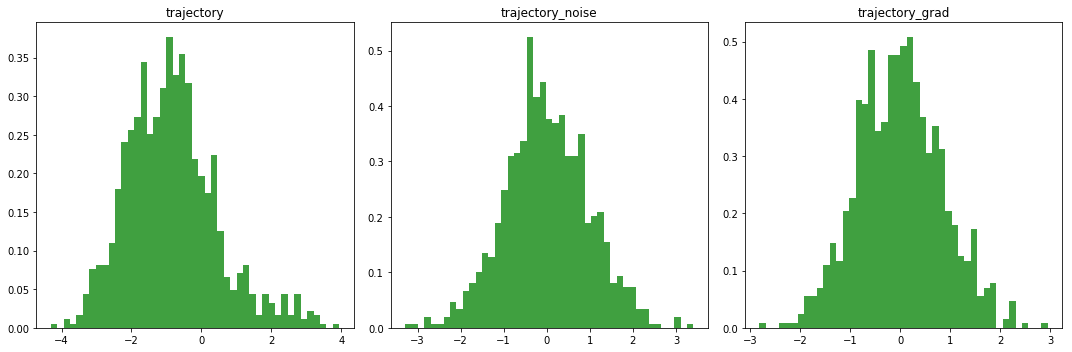

In [147]:
plot_distr(XX_test[0], ZZ_test[0], GG_test[0], 1)

# Check algo1.py

In [149]:
import Algo1

In [150]:
from sklearn.preprocessing import PolynomialFeatures

In [151]:
# import importlib
# importlib.reload(Algo1)

In [152]:
Betas, degrees = Algo1.G_pml_fit_meansum(XX,max_deg=2)

100%|██████████| 1000/1000 [00:14<00:00, 67.99it/s]


In [153]:
# def G_pml_predict(x, pml, Betas, max_deg = 1):
#     poly = PolynomialFeatures(max_deg)
#     x_pol = poly.fit_transform(x.reshape(1,-1))
#     beta = Betas[pml]
#     return (x_pol @ beta)


# pml = 1
# # Make data.
# X_plot = np.linspace(Algo1(XX,pml)[:,1].min(), generate_X_reduced(XX,pml)[:,1].max(),num = 50)
# Y_plot = np.linspace(generate_X_reduced(XX,pml)[:,2].min(), generate_X_reduced(XX,pml)[:,2].max(),num = 50)
# X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
# Z_plot_real = X_plot + Y_plot

# Z_plot = np.empty((X_plot.shape[0],X_plot.shape[0]))
# for i in range(X_plot.shape[0]):
#     XY_plot = np.hstack((X_plot[i].reshape(-1,1,1), Y_plot[i].reshape(-1,1,1)))
#     for j in range(X_plot.shape[0]):
#         Z_plot[i,j] = G_pml_predict(XY_plot[j],pml,Betas)
        
# predict_plot = go.Surface(x = X_plot, y = Y_plot,z=Z_plot)
# real_scatter = go.Scatter3d(
#     x=generate_X_reduced(XX,pml)[:,1],
#     y=generate_X_reduced(XX,pml)[:,2],
#     z=generate_y_reduced(XX,pml),
#     mode='markers',
#     marker=dict(
#         size=5,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )       
        
# data = [predict_plot, real_scatter]
# plotly.offline.plot(data, filename="surface_G_pml={}".format(pml))

In [154]:
d = 2
k_comb = np.zeros((d,d), dtype=np.int16)
for i in range(d):
    k_comb[i,i] = 1

In [155]:
k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

In [156]:
k_comb

array([[1, 0],
       [0, 1],
       [1, 1],
       [2, 0],
       [0, 2]], dtype=int16)

In [157]:
import timeit
from tqdm import tqdm
from joblib import Parallel, delayed

In [158]:
def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [109]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX[0])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX[0],GG[0], ZZ[0], 0.1, degrees,Betas, 25)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-3.8474688426183765
p ([1 0]) = -3.861414212895461 [Time:22.739168416999746]
p ([0 1]) = -3.6888421380712693 [Time:40.787131844001124]
p ([1 1]) = -3.6944837293085127 [Time:56.41220686699671]
p ([2 0]) = -3.70041743416729 [Time:97.78510450799513]
p ([0 2]) = -3.6887239570875723 [Time:136.59541691999766]
-3.6887239570875723


In [110]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX[0])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX[0],GG[0], ZZ[0], 0.1, degrees,Betas, 150)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-3.8474688426183765
p ([1 0]) = -3.886533169487687 [Time:84.92151717200613]
p ([0 1]) = -3.6610891963582173 [Time:141.05248937700526]
p ([1 1]) = -3.6671696965746565 [Time:186.2257971500003]
p ([2 0]) = -3.6761267976346983 [Time:296.4488939970033]
p ([0 2]) = -3.6494176592206955 [Time:386.49115375900146]
-3.6494176592206955


In [167]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], 0.1, degrees,Betas, 25)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.8306887602067328
p ([1 0]) = -1.7720933244401735 [Time:12.47900696999568]
p ([0 1]) = -1.6793719746649531 [Time:24.293744306000008]
p ([1 1]) = -1.6788192441963348 [Time:32.8264050200014]
p ([2 0]) = -1.6891730002404168 [Time:54.42820087199652]
p ([0 2]) = -1.6811855272995446 [Time:76.66405888699956]
-1.6811855272995446


In [168]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], 0.1, degrees,Betas, 50)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.8306887602067328
p ([1 0]) = -1.7559052824040424 [Time:22.012320995003392]
p ([0 1]) = -1.5807672486600775 [Time:45.25652644200454]
p ([1 1]) = -1.5795442458598505 [Time:63.084873054001946]
p ([2 0]) = -1.5989259822084079 [Time:106.59168725799827]
p ([0 2]) = -1.5834789447902446 [Time:151.04859876500268]
-1.5834789447902446


In [169]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], 0.1, degrees,Betas, 100)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.8306887602067328
p ([1 0]) = -1.7528072904028194 [Time:41.52654343899485]
p ([0 1]) = -1.5152690044128623 [Time:83.54950937699323]
p ([1 1]) = -1.5138905802787122 [Time:116.41440807599429]
p ([2 0]) = -1.5386969794087546 [Time:201.77975928999513]
p ([0 2]) = -1.515949230487751 [Time:285.2280641029938]
-1.515949230487751


In [170]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[1],GG_test[1], ZZ_test[1], 0.1, degrees,Betas, 25)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.2348075243105776
p ([1 0]) = -1.3512299319804697 [Time:10.722325996997824]
p ([0 1]) = -1.40676557499867 [Time:21.9870748599933]
p ([1 1]) = -1.4105167597315293 [Time:30.37911418799922]
p ([2 0]) = -1.4199139988172493 [Time:51.606789181998465]
p ([0 2]) = -1.409604278955948 [Time:73.42182471599517]
-1.409604278955948


In [171]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[1],GG_test[1], ZZ_test[1], 0.1, degrees,Betas, 50)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.2348075243105776
p ([1 0]) = -1.3938815864300513 [Time:21.31477060400357]
p ([0 1]) = -1.4617853391961422 [Time:42.840101697001955]
p ([1 1]) = -1.4691589413120785 [Time:61.558576937997714]
p ([2 0]) = -1.4879159369085921 [Time:102.744485600997]
p ([0 2]) = -1.4673917095499043 [Time:145.9680815440006]
-1.4673917095499043


In [173]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[1])
print (p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[1],GG_test[1], ZZ_test[1], 0.1, degrees,Betas, 100)
    print ("p ({}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))
print (p)

-1.2348075243105776
p ([1 0]) = -1.4103917359267022 [Time:40.181989279000845]
p ([0 1]) = -1.485429395247551 [Time:81.45745938999607]
p ([1 1]) = -1.4945250111776898 [Time:113.31448301600176]
p ([2 0]) = -1.5202056476997785 [Time:194.20527218999632]
p ([0 2]) = -1.4901595347664411 [Time:275.8461545800019]
-1.4901595347664411


# check on Test

In [174]:
P_test = estimator(XX_test)

100%|██████████| 50/50 [00:00<00:00, 4602.15it/s]


In [175]:
M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, 0.1, degrees,Betas, 100, n_jobs=2)

In [176]:
print ('               Variance of Pi = ',P_test.var(ddof = 1))
for i in range(1,d+1):
    print ('Variance of new estimator (K=1)=',(P_test-M_test[:i].sum(axis = 0)).var(ddof = 1))

               Variance of Pi =  0.26138566366180993
Variance of new estimator (K=1)= 0.19167586698856326
Variance of new estimator (K=1)= 0.02682726099641046


In [202]:
np.save('logs_custom/M_test.npy', M_test )

FileNotFoundError: [Errno 2] No such file or directory: 'logs_custom/M_test.npy'

In [196]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
#     samples = np.concatenate((traj, np.square(traj)), axis=1)
    cov1 = np.cov(traj_grad, rowvar=False)
    A = np.linalg.inv(cov1)
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
#     print(paramZV1)
    return mean_ZV1

def ZVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
#     samples = np.concatenate((traj, np.square(traj)), axis=1)
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j]) \
                    -np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(Lpoisson, rowvar=False)
    A = np.linalg.inv(cov1)
    cov2 = np.cov(np.concatenate((Lpoisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramZV2 = - np.dot(A,B)
    ZV2 = samples + np.dot(Lpoisson, paramZV2)
    mean_ZV2 = np.mean(ZV2, axis = 0)
    return mean_ZV2

def CVpolyOne(traj,traj_grad):
    n, d = traj.shape
#     samples = np.concatenate((traj, np.square(traj)), axis=1)
    samples = traj.sum(axis = 1).reshape(-1,1)
    covariance = np.cov(np.concatenate((traj, samples), axis=1), rowvar=False)
    paramCV1 = covariance[:d, d:]
    CV1 = samples - np.dot(traj_grad, paramCV1)
    mean_CV1 = np.mean(CV1, axis = 0)
    return mean_CV1

def CVpolyTwo(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
#     samples = np.concatenate((traj, np.square(traj)), axis=1)
    poisson = np.zeros((n,int(d*(d+3)/2)))
    poisson[:,np.arange(d)] = traj
    poisson[:,np.arange(d, 2*d)] = np.multiply(traj, traj)
    k = 2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            poisson[:,k] = np.multiply(traj[:,i], traj[:,j])
            k=k+1
    Lpoisson = np.zeros((n,int(d*(d+3)/2)))
    Lpoisson[:,np.arange(d)] = - traj_grad
    Lpoisson[:,np.arange(d, 2*d)] = 2*(1. - np.multiply(traj, traj_grad))
    k=2*d
    for j in np.arange(d-1):
        for i in np.arange(j+1,d):
            Lpoisson[:,k] = -np.multiply(traj_grad[:,i], traj[:,j]) \
                    -np.multiply(traj_grad[:,j], traj[:,i])
            k=k+1
    
    cov1 = np.cov(np.concatenate((poisson, -Lpoisson), axis=1), rowvar=False)
    A = np.linalg.inv(cov1[0:int(d*(d+3)/2), int(d*(d+3)/2):d*(d+3)])
    cov2 = np.cov(np.concatenate((poisson, samples),axis=1), rowvar=False)
    B = cov2[0:int(d*(d+3)/2), int(d*(d+3)/2):]
    paramCV2 = np.dot(A,B)
    CV2 = samples + np.dot(Lpoisson, paramCV2)
    mean_CV2 = np.mean(CV2, axis = 0)
    return mean_CV2

res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(CVpolyOne(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(CVpolyTwo(XX_test[i].reshape(-1,d), GG_test[i].reshape(-1,d)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [178]:
print (res_cv_1.var(ddof=1))
print (res_cv_2.var(ddof=1))
print (res_zv_1.var(ddof=1))
print (res_zv_2.var(ddof=1))

0.03794834661183037
0.029106108224007537
0.052212813939284786
0.025519256327141564


In [179]:
from matplotlib import pyplot as plt

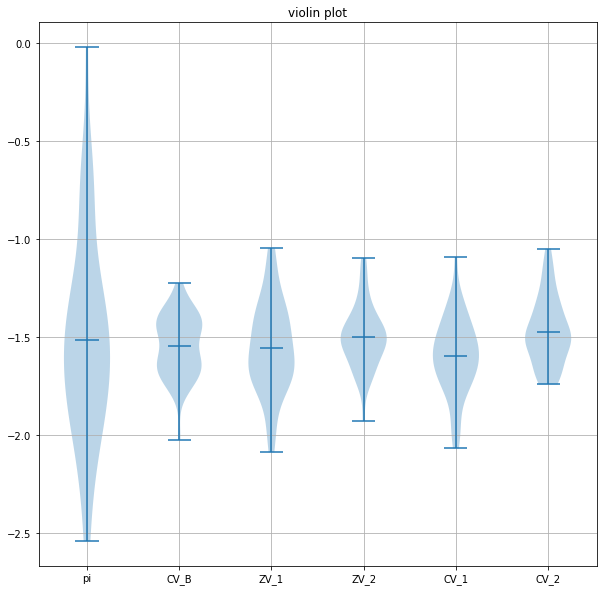

In [180]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(
        all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,7), ('pi', 'CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [200]:
print ('               Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

               Variance of Pi =  0.26138566366180993
Variance of new estimator = 0.26138566366180993
Variance of new estimator = 0.19167586698856326
Variance of new estimator = 0.02682726099641046
Variance of new estimator = 0.025608594646184646
Variance of new estimator = 0.025865230907844972
        Variance of CV 1 =  0.03794834661183037
        Variance of CV 2 =  0.029106108224007537
        Variance of ZV 1 =  0.052212813939284786
        Variance of ZV 2 =  0.025519256327141564
